In [1]:
import hdbscan
import numpy as np
from sklearn.metrics import v_measure_score
from sklearn.cluster import KMeans
import umap    
import umap.plot
from torch.utils.data import DataLoader

from pathlib import Path
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, SimilarityFunction, losses
import sys
import os
import logging

SCRIPT_DIR = Path.cwd().parent
sys.path.insert(0, str(SCRIPT_DIR))

from embeddings.embedding_library import EmbeddingLibrary

c:\Users\rooty\UWEC\Fall 24\CS 426\GroupProject\GroupProject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rooty\UWEC\Fall 24\CS 426\GroupProject\GroupProject\lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\rooty\UWEC\Fall 24\CS 426\GroupProject\GroupProject\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarn

In [2]:
path_to_papers = Path(r'../papers')
path_to_embs = Path(r'../data/embeddings')

# should all be lower case
end_of_paper_words = [
    'references',
    'acknowledgement', 
    'appendix',
]

papers_to_skip = [
    '2311.11329v2_content.txt',
    '2411.09324v2_content.txt',
    '2411.14259v1_content.txt',
    #'2403.12778v2_content.txt' 
]

In [3]:
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1', device='cuda')

In [4]:
emb_lib = EmbeddingLibrary(
    path_to_papers=path_to_papers,
    path_to_embs=path_to_embs,
    model=model,
    end_of_paper_words=end_of_paper_words,
    papers_to_skip=papers_to_skip,
    norm_embs=True,
    name="distilroberta-v1",
    log_lvl=logging.DEBUG,
    path_to_log=Path("../log")
)

In [5]:
emb_lib.multi_sec_embed(skip_existing=False)

Batches: 100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


In [6]:
paper_embs = []
for file in sorted(path_to_embs.iterdir()):
    paper_embs.append(np.load(file))
all_embs = np.concatenate(paper_embs, axis=0)

In [7]:
all_embs.shape

(46, 768)

In [8]:
embs = emb_lib.get_paper_embs()

In [9]:
mapper = umap.UMAP().fit(embs)

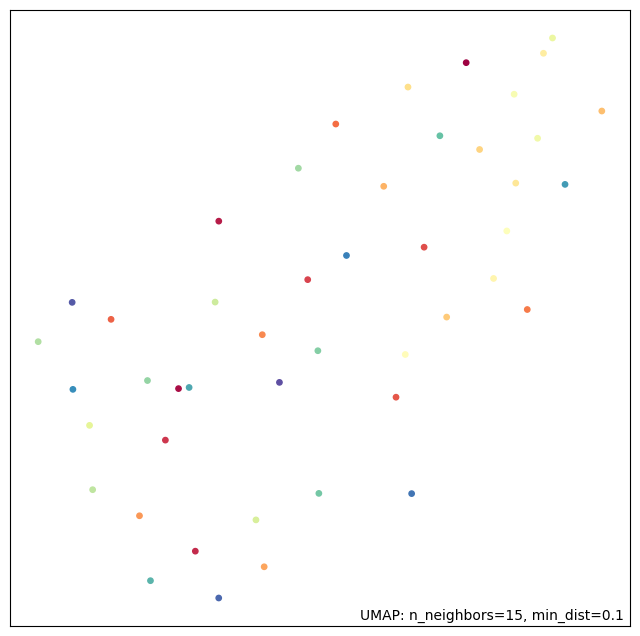

In [10]:

p = umap.plot.points(mapper, labels=pd.Series([i for i in range(embs.shape[0])]), show_legend=False)
umap.plot.show(p)

In [11]:
model.similarity_fn_name = SimilarityFunction.COSINE

In [12]:
model.similarity(embs, embs)

tensor([[1.0000, 0.1973, 0.3841,  ..., 0.5426, 0.3374, 0.3162],
        [0.1973, 1.0000, 0.3558,  ..., 0.2475, 0.3143, 0.4754],
        [0.3841, 0.3558, 1.0000,  ..., 0.3466, 0.4973, 0.3639],
        ...,
        [0.5426, 0.2475, 0.3466,  ..., 1.0000, 0.3382, 0.3323],
        [0.3374, 0.3143, 0.4973,  ..., 0.3382, 1.0000, 0.2821],
        [0.3162, 0.4754, 0.3639,  ..., 0.3323, 0.2821, 1.0000]])

In [21]:
# Paper: 2311.00207v3

prompt = ""
response = '''SECTION: IIntroduction

Next-generation (NextG) networks promise to support ultra-reliable and low-latency communication for rapidly evolving wireless devices[29]. Emerging networks are thus challenged to establish new features (e.g., adaptive coding and enhanced modulation) to overcome rapidly changing channel conditions and to achieve more efficient use of spectrum[102,63].
Machine Learning (ML) overcomes this barrier by revolutionizing the entire wireless network protocol stack[67].

Recent research[19]introduces joint source-channel coding (JSCC), an end-to-end wireless communication system leveraging deep neural networks (DNNs) for both transmitter and receiver. This ML approach jointly optimizes source and channel coding in a cross-layer framework to handle diverse and challenging channel conditions.
To effectively cope with the multipath fading effects, the JSCC-encoded data can be further modulated into continuous signal waveforms through orthogonal frequency division multiplexing (OFDM)[99].
The DNN models for JSCC are tailored to specific modalities (e.g., texts, images, etc.), so as to convey semantic information more accurately than traditional communication systems (seesectionII-B).
The advantages of such ML-based communication systems are increasingly recognized by standardization bodies such as the Third Generation Partnership Project (3GPP)[84].Industry leaders, such as Apple[70], Huawei[88], Nokia Bell Labs[7], Qualcomm[64], and ZTE[51]are also investigating AI-native 6G communications. NVIDIA has established an ML-based, GPU-accelerated communication signal processing framework[39]for 6G applications. These developments underscore the growing consensus that ML-based wireless communications will play a crucial role in shaping the future of 6G technology.

Unfortunately, ML is vulnerable to adversarial attacks[77,16], where small, imperceptible changes to input can yield substantial changes in the model’s output.
The susceptibility of the models to adversarial examples raises serious concerns for the safety of ML adoption in NextG.

Traditional jamming or overshadowing attacks[93,97,76,30]have been dedicated to developing a malicious RF device to disrupt legitimate wireless communications. However, these approaches typically rely on high-power transmissions to cause large-scale disruptions in the spectrum, leading spectrum owners to respond swiftly.
Highly effective attacks that use low signal strengths are missing in this literature.

There have been recent works on small signal manipulations designed to target ML-based wireless systems[13,60,48,40,55].
However, they make unrealistic assumptions about the attacker’s capabilities. For example, even though JSCC has a modality-specific structure, they assume that only a single modality (e.g., one-hot vector message or image) is wirelessly communicated. They also assume that the adversary knows which modality is sent by the transmitter.
In practice, the above assumptions are not valid for the following reasons: 1) the transmitter typically incorporates data from all modalities into the data blocks and then sends them to the receiver; 2) if the adversary wants to recognize the modality of the signal, it needs to have access to the target ML model that carries out JSCC, and this is not always feasible, and 3) even if the adversary can detect the modality, high latency occurs until perturbations are generated and added to the victim signal.

We propose Magmaw, a new hardware-driven wireless attack framework that creates universal adversarial perturbations (UAPs) to subvert ML-based wireless systems. We show for the first time that modulated multimodal data can be perturbed by adversaries, resulting in failure to restore the original data as well as subversion of downstream services. We consider examples of downstream services such as video classification (VC), which analyzes human activity from video, and audio-visual event recognition (AVE) which predicts the event label based on representations over multiple input modalities.
Magmaw can cause significant disruptions or threaten user safety in quality-sensitive applications, e.g., remote surgery[4]and autonomous driving[37], as illustrated in Figure1. Emerging applications (e.g., XR[49]) would suffer even more from the corruption of multiple input modalities.

Magmaw must address four main design challenges.Firstly, we assume that the adversary lacks prior knowledge about the data’s modality and the exact channel model. Additionally, the attacker’s ability to adjust its transmit signal pattern effectively depends on knowing the channel matrix between the sender and receiver ().
However, sincevaries due to factors like link distance, mobility, and environment, not having this information makes crafting an effective attack challenging.
We solve the above challenges by designing a perturbation generator model (PGM) trained to create input- and channel-agnostic perturbations on surrogate wireless models. We adopt an ensemble learning approach that utilizes surrogate multimodal JSCC models to learn UAPs.

Secondly, previous attacks[13,60,48,40,55]do not consider that the input signal can be adjusted by physical layer protocols (seesectionII-C). They only focus on the scenarios where the adversary has prior knowledge of the protocol’s full setup. In a practical scenario, the attacker does not know the constellation mapping or how the OFDM system assigns the complex symbols to multiple subcarriers.It is possible to design an attacker that recognizes the protocol from the transmitted signals[73]. However, since wireless protocols change rapidly depending on the channel state, the analyzed output quickly becomes obsolete. A protocol-agnostic attack is required.We address this challenge by incorporating multiple controllable parameters inside the ensemble learning to optimize perturbations generalizable across all modulated data.

Thirdly, an adversarial wireless device may not be precisely synchronized with a legitimate transmitter or receiver in the time or frequency domain, reducing the effectiveness of perturbations.
We address de-synchronization issues between the adversarial device and the legitimate transmitter/receiver using our offline training procedure. Specifically, we train the PGM using time shift and phase rotation functions, ensuring that UAPs remain effective even with varying offsets.

Finally, previous studies[13,55]are vulnerable to adaptive defenses. For instance, a perturbation detector[94]can exploit traces of perturbations to predict whether the input is perturbed. This is because their perturbations are overly rigid and lacking in variability due to overfitting[35]. To craft robust and diverse perturbations, we introduce a discriminator and diversity loss to regularize the learning process explicitly.

After integrating the above solutions, we implement Magmaw on the software-defined radio platform and validate its attack feasibility, as shown in AppendixA. Our experiments show that Magmaw degrades the Peak Signal-to-Noise Ratio (PSNR) by up to 8.04dB and 8.29dB for image and video transmission, respectively, where PSNR is a representative image quality score. For speech transmission, Magmaw prevents receivers from recognizing the speech content, increasing the mean square error (MSE) by up to 3.91compared to baseline attacks. Furthermore, Magmaw reduces the bilingual evaluation understudy (BLEU) score to 0.338 points for text transmission, indicating that the received text exhibits significant semantic errors and grammatical inaccuracies. Notably, we achieve up to 91.2attack success rate on the downstream tasks.
In our case study, we establish an encryption-based secure image transmission and prove that Magmaw leads to a reduction of up to 5.88dB in PSNR.We also evaluate Magmaw with channel modality-based ML models. Magmaw introduces up tomore error in the ML results than the baseline.

In summary, we make the following contributions:

We introduce Magmaw,a novel wireless attack frameworkimplemented over software-defined radio against ML-based multimodal communication systems and underlying downstream applications.

We adopt an ensemble learning on a set of surrogate JSCCs to craft our UAP input- and protocol-agnostic, i.e., oblivious to the modality, constellation, coding rate, OFDM specifications, and channel conditions.

We evaluate Magmaw against various defense techniques, including adaptive ones. Extensive results from case studies further show Magmaw’s efficacy.

SECTION: IIBackground

SECTION: II-AWireless Communication Systems

Current communication standards (e.g., 4G LTE[3], IEEE 802.11 family[41], 5G NR[50]) follow separate source and channel coding designs and require independent optimization of each component. The source encoder transforms the source data into the embedded source bits. The channel encoder adds redundancy to the transmitted signal, allowing the receiver to correct errors caused by noise. However, these conventional systems suffer from dramatic performance degradation due to the cliff effect where the receiver’s error correction algorithm cannot recover the transmitted data if channel conditions are worse than a certain threshold[19].

ML-driven wireless systems aim to train a robust JSCC encoder and decoder on wireless channels infused with channel conditions similar to the physical world. The JSCC encoder directly maps the source to complex-valued symbols, and the JSCC decoder recovers its estimate directly from the noisy channel output. To adopt the widely used wireless standards, the JSCC models can be concatenated with OFDM to increase the spectral efficiency and reduce the multipath channel effects[99]. Since multipath fading channels and OFDM blocks can be represented as differentiable layers, ML-based wireless systems are trained end-to-end.As such, JSCC can be built without modifying standard radio hardware (e.g., field test 6G with JSCC on 4G LTE[85]). Furthermore, ML-based wireless communication can significantly save channel bandwidth costs compared to conventional systems while achieving the same end-to-end wireless transmission performance[100].

SECTION: II-BModality-Specific JSCC Models

Existing JSCC systems[99,83,89,91]adopt modality-specific structures, with each modality requiring a specialized approach for accurate symbol recovery at the receiver.
We consider four state-of-the-art JSCC models for image[99], video[83], speech[89], and text transmission[91].
Figure2depicts the commonly used structures for each modality.
The image JSCC is trained to minimize distortion on a frame-by-frame basis. The video JSCC leverages spatiotemporal similarities between successive frames to remove the redundancy. To achieve this, the video JSCC adopts the temporal coding structure, which clusters each consecutive sequence of pictures into a group of pictures (GOP). Each frame within the GOP is entered into the video JSCC in coding order rather than display order. This means that the video JSCC encoder compresses frames in a specific order.
For a total offrames included in the GOP, the coding order of each frame is determined by the mapping function, where.
On the other hand, speech signals contain speaker characteristics such as speech rate and tone. The attention mechanism[89]is utilized for speech JSCC to identify the essential features to help accurately recover speech signals at the receiver. The text JSCC is designed to precisely encode context information and cope with semantic distortion based on Transformers[82]. The text features recovered by the receiver are decoded into the text sentence through a greedy decoder[86]. A cross-entropy loss[47]is used to understand semantic meaning while maximizing system capacity.'''

r_secs = emb_lib.preprocess_llm_response(prompt, response)
print(r_secs)
r_emb = emb_lib.model.encode(r_secs, normalize_embeddings=emb_lib.norm_embs).mean(axis=0)
scores = emb_lib.model.similarity(r_emb, emb_lib.paper_embs)
top_n_idxs = np.argsort(scores).tolist()[0][-5:]
top_paper_ids = [emb_lib.paper_ids[idx] for idx in top_n_idxs]
top_paper_ids

['Next-generation (NextG) networks promise to support ultra-reliable and low-latency communication for rapidly evolving wireless devices. Emerging networks are thus challenged to establish new features (e.g., adaptive coding and enhanced modulation) to overcome rapidly changing channel conditions and to achieve more efficient use of spectrum.', 'Machine Learning (ML) overcomes this barrier by revolutionizing the entire wireless network protocol stack.', 'Recent research introduces joint source-channel coding (JSCC), an end-to-end wireless communication system leveraging deep neural networks (DNNs) for both transmitter and receiver. This ML approach jointly optimizes source and channel coding in a cross-layer framework to handle diverse and challenging channel conditions.', 'To effectively cope with the multipath fading effects, the JSCC-encoded data can be further modulated into continuous signal waveforms through orthogonal frequency division multiplexing (OFDM).', 'The DNN models for

Batches: 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


['2407.05941v4',
 '2411.09101v1',
 '2411.13037v1',
 '2406.08298v5',
 '2311.00207v3']

In [19]:
emb_lib.paper_ids == [file.stem for file in sorted(path_to_embs.iterdir())]

True

In [17]:
top_n_idxs

[22, 38, 4, 33, 35]

**These results are sub-par**

### Finetuning

In [8]:
import re

In [6]:
txt = '''SECTION: Delegating Data Collection in Decentralized Machine Learning

Motivated by the emergence of decentralized machine learning (ML) ecosystems, we study the delegation of data collection. Taking the field of contract theory as our starting point, we design optimal and near-optimal contracts that deal with two fundamental information asymmetries that arise in decentralized ML: uncertainty in the assessment of model quality and uncertainty regarding the optimal performance of any model. We show that a principal can cope with such asymmetry via simple linear contracts that achievefraction of the optimal utility. To address the lack of a priori knowledge regarding the optimal performance, we give a convex program that can adaptively and efficiently compute the optimal contract. We also study linear contracts and derive the optimal utility in the more complex setting of multiple interactions.

SECTION: 1Introduction

The design of machine learning pipelines is increasingly a cooperative, distributed endeavor, in which the expertise needed for the design of various components of an overall pipeline is spread across many stakeholders. Such'''

In [9]:
chunks = [
    chunk
    for sec in re.split(r'SECTION:\s+[\d\.]*.*\n', txt)
    for chunk in sec.strip('\n').split('\n')
    if chunk != ''
]

In [10]:
chunks

['Motivated by the emergence of decentralized machine learning (ML) ecosystems, we study the delegation of data collection. Taking the field of contract theory as our starting point, we design optimal and near-optimal contracts that deal with two fundamental information asymmetries that arise in decentralized ML: uncertainty in the assessment of model quality and uncertainty regarding the optimal performance of any model. We show that a principal can cope with such asymmetry via simple linear contracts that achievefraction of the optimal utility. To address the lack of a priori knowledge regarding the optimal performance, we give a convex program that can adaptively and efficiently compute the optimal contract. We also study linear contracts and derive the optimal utility in the more complex setting of multiple interactions.',
 'The design of machine learning pipelines is increasingly a cooperative, distributed endeavor, in which the expertise needed for the design of various component

In [34]:
secs = [
    chunk
    for sec in re.split(r'SECTION:\s+[\d\.]*.*\n', txt)
    for chunk in sec.strip('\n').split('\n')
    if chunk != ''
]
secs

['Motivated by the emergence of decentralized machine learning (ML) ecosystems, we study the delegation of data collection. Taking the field of contract theory as our starting point, we design optimal and near-optimal contracts that deal with two fundamental information asymmetries that arise in decentralized ML: uncertainty in the assessment of model quality and uncertainty regarding the optimal performance of any model. We show that a principal can cope with such asymmetry via simple linear contracts that achievefraction of the optimal utility. To address the lack of a priori knowledge regarding the optimal performance, we give a convex program that can adaptively and efficiently compute the optimal contract. We also study linear contracts and derive the optimal utility in the more complex setting of multiple interactions.',
 'The design of machine learning pipelines is increasingly a cooperative, distributed endeavor, in which the expertise needed for the design of various component

In [25]:
cln_txt = re.search(r'SECTION:\s+[\d\.]*(.*)\n', txt, flags=re.IGNORECASE)
cln_txt

<re.Match object; span=(0, 70), match='SECTION: Delegating Data Collection in Decentrali>

In [28]:
cln_txt.group(1)

'Delegating Data Collection in Decentralized Machine Learning'

In [12]:
from sentence_transformers import InputExample

In [ ]:
# prepare data

In [13]:
InputExample(texts=[text, text] for text in ).

sentence_transformers.readers.InputExample.InputExample

In [ ]:


# DataLoader to batch your data
train_dataloader = DataLoader(train_data, batch_size=20, shuffle=True)

# Use the MultipleNegativesRankingLoss
train_loss = losses.MultipleNegativesRankingLoss(model)